## CRISP-DM Phase 3. Data Preparation

The data preparation phase covers all activities needed to construct the final dataset [data that will be fed into the modeling tool(s)] from the initial raw data. Tasks include table, record, and attribute selection, as well as transformation and cleaning of data for modeling tools

In [22]:
import sys
sys.path.append('../src')
import utils
import data_processor
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import warnings 
warnings.filterwarnings('ignore')

# Load data
df: pd.DataFrame = utils.load_original_data()

# Data preprocessing object
processor = data_processor.DataProcessor(df)

### Converting Target Variable into binary values in conformance with a classification problem

In [23]:
# Convert Financial Distress column into 0 or 1
df['Financial Distress'] = [0 if x > -0.50 else 1 for x in df['Financial Distress']]

df.head()

,Company,Time,Financial Distress,x1,x2,x3,x4,x5,x6,x7,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,0,1.2810,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
1,1,2,0,1.2700,0.006454,0.82067,1.00490,-0.014080,0.181040,0.62288,...,107.090,31.31,30.194,17.000,16.0,0.4,22,0.010636,31,50
2,1,3,0,1.0529,-0.059379,0.92242,0.72926,0.020476,0.044865,0.43292,...,120.870,36.07,35.273,17.000,15.0,-0.2,22,-0.455970,32,51
3,1,4,1,1.1131,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
4,2,1,0,1.0623,0.107020,0.81460,0.83593,0.199960,0.047800,0.74200,...,85.437,27.07,26.102,16.000,16.0,0.2,29,1.251000,7,27


In [24]:
# Create feature matrix and target vector 
X, y = processor.create_feature_matrix_and_target_vector("Financial Distress")

### Balancing Data

Two different techniques were combined to address class imbalance:
- SMOTE: Oversample the minority class  
- Random Undersampling: Undersample the majority class 

Counter({0: 3536, 1: 136})


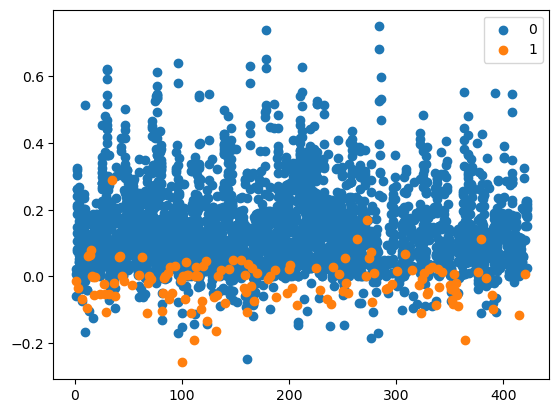

In [25]:
# Check class distribution
processor.class_distribution(X,y)

How the SMOTE synthesizes new examples for the minority class:
- SMOTE first selects a minority class instance at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

Counter({0: 2120, 1: 1060})


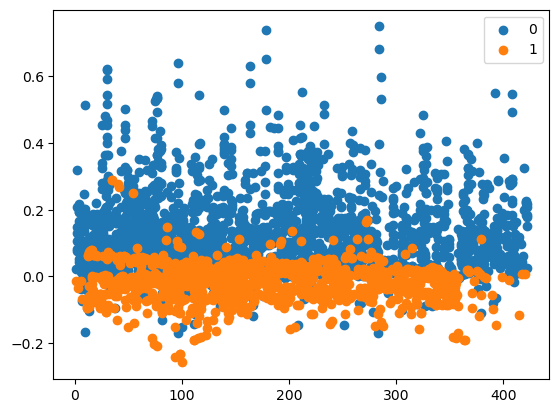

In [26]:
# Transform data with SMOTE for minority class and RandomUnderSampler for majority class to tackle class imbalance
X_sampled, y_sampled = processor.transform(X, y,0.3,0.5)

- The final class distribution after this sequence of transforms matches expectations with a 1:2 ratio or about 2,000 examples in the majority class and about 1,000 examples in the minority class.

In [27]:
sampled_sorted = X_sampled.sort_values(by=['Company'])
sampled_sorted

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,1,1,1.28100,0.022934,0.87454,1.21640,0.060940,0.188270,0.52510,0.018854,...,85.437,27.07,26.102,16.000,16.0,0.2,22,0.060390,30,49
3,1,4,1.11310,-0.015229,0.85888,0.80974,0.076037,0.091033,0.67546,-0.018807,...,54.806,39.80,38.377,17.167,16.0,5.6,22,-0.325390,33,52
15,2,12,2.17230,0.319450,0.44139,0.94698,0.427400,0.481260,1.39200,0.337340,...,87.100,175.90,178.100,20.000,14.5,-20.2,29,2.827700,18,38
5,2,2,1.05580,0.081916,0.87949,0.68673,0.142630,0.043102,0.77198,0.119280,...,107.090,31.31,30.194,17.000,16.0,0.4,29,1.357300,8,28
6,2,3,0.97059,0.076064,0.90677,0.80980,0.165920,-0.024649,0.73660,0.093929,...,120.870,36.07,35.273,17.000,15.0,-0.2,29,0.007188,9,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671,422,14,1.61480,0.176760,0.36369,0.18442,0.169550,0.197860,1.58420,0.958450,...,91.700,227.50,214.500,21.000,20.5,8.6,37,0.611030,8,45
3665,422,8,2.06090,0.149950,0.18973,0.14381,0.132120,0.199190,1.98920,1.042700,...,84.660,73.20,63.880,16.000,12.0,1.2,37,0.351440,2,39
3668,422,11,1.96150,0.216440,0.20095,0.21642,0.203590,0.189870,1.93820,1.000100,...,91.500,130.50,132.400,20.000,14.5,-16.0,37,0.438020,5,42
3669,422,12,1.70990,0.207970,0.26136,0.21399,0.193670,0.183890,1.68980,0.971860,...,87.100,175.90,178.100,20.000,14.5,-20.2,37,0.482410,6,43


In [28]:
# check if Time is monotonic and increasing for each group/company 
print("Time monotonic and increasing for each group/company in original data: {}".format(processor.check_time_monotonicity(X, "Time")))
print("Time monotonic and increasing for each group/company in sampled data: {}".format(processor.check_time_monotonicity(X_sampled, "Time")))

Time monotonic and increasing for each group/company in original data: True
Time monotonic and increasing for each group/company in sampled data: False


- It seems that the temporal order of the 'Time' column is not being preserved within each group (company) in the sampled data.

In [29]:
# Preserve temporal order of data for each group/company
X_sampled_sorted = X_sampled.sort_values(by=['Company', 'Time'])
print(X_sampled_sorted.head())

# sort y_sampled according to X_sampled_sorted 
y_sampled_sorted = y_sampled[X_sampled_sorted.index]
# reset index
y_sampled_sorted = y_sampled_sorted.reset_index(drop=True)
print(y_sampled_sorted.head())

   Company  Time       x1        x2       x3       x4        x5        x6  \
0        1     1  1.28100  0.022934  0.87454  1.21640  0.060940  0.188270   
3        1     4  1.11310 -0.015229  0.85888  0.80974  0.076037  0.091033   
4        2     1  1.06230  0.107020  0.81460  0.83593  0.199960  0.047800   
5        2     2  1.05580  0.081916  0.87949  0.68673  0.142630  0.043102   
6        2     3  0.97059  0.076064  0.90677  0.80980  0.165920 -0.024649   

        x7        x8  ...      x74    x75     x76     x77   x78  x79  x80  \
0  0.52510  0.018854  ...   85.437  27.07  26.102  16.000  16.0  0.2   22   
3  0.67546 -0.018807  ...   54.806  39.80  38.377  17.167  16.0  5.6   22   
4  0.74200  0.128030  ...   85.437  27.07  26.102  16.000  16.0  0.2   29   
5  0.77198  0.119280  ...  107.090  31.31  30.194  17.000  16.0  0.4   29   
6  0.73660  0.093929  ...  120.870  36.07  35.273  17.000  15.0 -0.2   29   

        x81  x82  x83  
0  0.060390   30   49  
3 -0.325390   33   52  
4 

In [30]:
# sum of null values in X_sampled and y_sampled
print("Number of NaN values in X_sampled: {}".format(X_sampled_sorted.isnull().sum().sum()))
print("Number of NaN values in y_sampled: {}".format(y_sampled_sorted.isnull().sum().sum()))

Number of NaN values in X_sampled: 0
Number of NaN values in y_sampled: 0


### Scaling

In [31]:
X_scaled_sampled : pd.DataFrame = processor.scale(X_sampled_sorted)
X_scaled: pd.DataFrame = processor.scale(X)
X_scaled_sampled

,Company,Time,x1,x2,x3,x4,x5,x6,x7,x8,...,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83
0,-1.589818,-1.520226,0.000767,-0.483193,1.130177,0.727879,-0.385056,0.568722,-0.180701,-0.024042,...,-0.101740,-0.962972,-0.937778,-0.859221,0.301344,0.346905,0.390886,-0.487484,1.844085,1.201516
1,-1.589818,-0.786716,-0.126518,-0.788023,1.041622,-0.037966,-0.267844,0.092288,-0.034162,-0.024048,...,-2.021114,-0.763878,-0.744601,-0.272518,0.301344,1.033372,0.390886,-0.763788,2.179578,1.436479
2,-1.580959,-1.520226,-0.165029,0.188452,0.791223,0.011356,0.694283,-0.119542,0.030687,-0.024023,...,-0.101740,-0.962972,-0.937778,-0.859221,0.301344,0.346905,1.405951,0.365257,-0.728026,-0.521550
3,-1.580959,-1.275723,-0.169957,-0.012069,1.158169,-0.269625,0.249178,-0.142560,0.059905,-0.024024,...,1.255062,-0.896659,-0.873380,-0.356476,0.301344,0.372330,1.405951,0.441392,-0.616196,-0.443229
4,-1.580959,-1.031219,-0.234555,-0.058812,1.312435,-0.037853,0.430000,-0.474521,0.025424,-0.024029,...,2.118533,-0.822214,-0.793450,-0.356476,-0.055485,0.296056,1.405951,-0.525589,-0.504365,-0.364908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3175,2.139797,0.191297,0.592011,0.531359,-2.742352,-1.292083,0.167580,0.622227,1.246190,-0.023864,...,-0.150428,-0.241511,-0.343248,-0.859221,-1.125974,0.474029,2.566024,-0.279028,-1.287181,0.418304
3176,2.139797,0.924807,0.516656,1.062454,-2.678904,-1.155339,0.722466,0.576562,1.196486,-0.023871,...,0.278175,0.654645,0.735085,1.151760,-0.233900,-1.712497,2.566024,-0.217017,-0.951688,0.653268
3177,2.139797,1.169310,0.325917,0.994799,-2.337292,-1.159916,0.645448,0.547261,0.954399,-0.023876,...,0.002465,1.364688,1.454288,1.151760,-0.233900,-2.246416,2.566024,-0.185224,-0.839857,0.731589
3178,2.139797,1.413813,0.211520,0.814918,-2.077619,-1.199313,0.478291,0.482536,0.807334,-0.023878,...,0.365900,1.791652,1.869757,2.157251,2.442320,1.135071,2.566024,-0.172074,-0.728026,0.809910


### Feature Selection

#### Recursive Feature Elimination

In [13]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=10)
rfe.fit(X_scaled, y_sampled_sorted)
print("Selected features after RFE: {}".format(X_scaled.columns[rfe.support_]))

Selected features after RFE: Index(['x2', 'x10', 'x14', 'x36', 'x46'], dtype='object')


### Save Data

In [32]:
# Append X and Y to create a single data frame
df_model = pd.DataFrame(X_scaled_sampled)
df_model['Financial Distress'] = y_sampled_sorted

# save data
with open('../data/processed/financial_data_processed_sampled.pkl', 'wb') as f:
    pkl.dump(df_model, f)

In [33]:
# Append X and Y to create a single data frame
df_model = pd.DataFrame(X_scaled)
df_model['Financial Distress'] = y

# save data
with open('../data/processed/financial_data_processed.pkl', 'wb') as f:
    pkl.dump(df_model, f)